## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use


file_path = Path(
    "../../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)

file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()
# df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
# df = df.assign(
#     Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
#     + "_"
#     + df["Metadata_dose"]
# )

# print("Unique Catagories are:")
# print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df specific to analysis and model
df = df.query(
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_10.000_DMSO_0.025' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
)
# for binary classification testing
# df = df.query(
#     "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
# )
print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
# Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'Thapsigargin_10.000_DMSO_0.025'
 'LPS_100.000_DMSO_0.025']
The dimensions of the data are: (64842, 2872)
Number of total missing values across all columns: 129684
Data Subset Is Off


In [5]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'L14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'E14' 'B15' 'C15' 'E15' 'J14' 'I15' 'J15' 'L15' 'J16' 'J17'
 'J20']


In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [8]:
output_name = (" ").join(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])} vs {(" ").join(output_name.split(" ")[2].split("_")[:2])}'

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [9]:
# if params.DATA_SUBSET_OPTION == 'True':
#     df = df.sample(n=params.DATA_SUBSET_NUMBER)
#     print("yes")
# else:
#     pass
# df_stats(df)
# # Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# # Check for Nans again
# df_stats(df)
# # Code snippet for metadata extraction by Jenna Tomkinson
# df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])
# # define which columns are data and which are descriptive
# df_descriptive = df[df_metadata]
# df_values = df.drop(columns=df_metadata)
# df_values_Y = df_values['Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256']
# df_values_X = df_values.drop('Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256', axis=1)

#### Split Data - All Models can proceed through this point

In [10]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [11]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [12]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  2847
Number of out features:  3
Multi_Class


In [13]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [14]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-05-08 19:52:33,995] A new study created in memory with name: no-name-02cf856a-7142-4393-bea1-c2f5b6f7152f
[I 2023-05-08 19:53:34,040] Trial 0 finished with value: 0.7981155596176783 and parameters: {'n_layers': 3, 'n_units_l0': 6, 'dropout_0': 0.29557735951685393, 'n_units_l1': 5, 'dropout_1': 0.24603887306911698, 'n_units_l2': 4, 'dropout_2': 0.1804274751129309, 'learning_rate': 0.0769274539602728, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7981155596176783.
[I 2023-05-08 19:54:31,792] Trial 1 finished with value: 0.4797029867768287 and parameters: {'n_layers': 1, 'n_units_l0': 10, 'dropout_0': 0.19360606886953802, 'learning_rate': 0.0263857580266415, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.4797029867768287.
[I 2023-05-08 19:55:29,209] Trial 2 finished with value: 0.3814269013206164 and parameters: {'n_layers': 1, 'n_units_l0': 2, 'dropout_0': 0.17264195102366792, 'learning_rate': 0.04807099605887862, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.

Validation Accuracy: 79.92272554244386
Validation Loss: 0.5143978761633238
Training Accuracy: 71.93608566329566
Training Loss: 0.5898015212181003


(79.92272554244386, 0.5143978761633238, 71.93608566329566, 0.5898015212181003)

In [15]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = Path(f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_optimization_history_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [16]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = Path(f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = (
    f"../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_intermediate_values_graph"
)
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [17]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [18]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
    params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 0.633003).  Saving model ...
	 Train_Loss: 0.8494 Train_Acc: 56.371 Val_Loss: 0.6330  BEST VAL Loss: 0.6330  Val_Acc: 70.023

Epoch 1: Validation loss decreased (0.633003 --> 0.558070).  Saving model ...
	 Train_Loss: 0.7625 Train_Acc: 69.689 Val_Loss: 0.5581  BEST VAL Loss: 0.5581  Val_Acc: 83.498

Epoch 2: Validation loss decreased (0.558070 --> 0.527505).  Saving model ...
	 Train_Loss: 0.7102 Train_Acc: 74.444 Val_Loss: 0.5275  BEST VAL Loss: 0.5275  Val_Acc: 83.041

Epoch 3: Validation loss decreased (0.527505 --> 0.503326).  Saving model ...
	 Train_Loss: 0.6743 Train_Acc: 76.145 Val_Loss: 0.5033  BEST VAL Loss: 0.5033  Val_Acc: 85.668

Epoch 4: Validation loss decreased (0.503326 --> 0.485104).  Saving model ...
	 Train_Loss: 0.6500 Train_Acc: 77.747 Val_Loss: 0.4851  BEST VAL Loss: 0.4851  Val_Acc: 86.886

Epoch 5: Validation loss decreased (0.485104 --> 0.475500).  Saving model ...
	 Train_Loss: 0.6334 Train_Acc: 78.123 Val_Loss

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:962: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:963: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



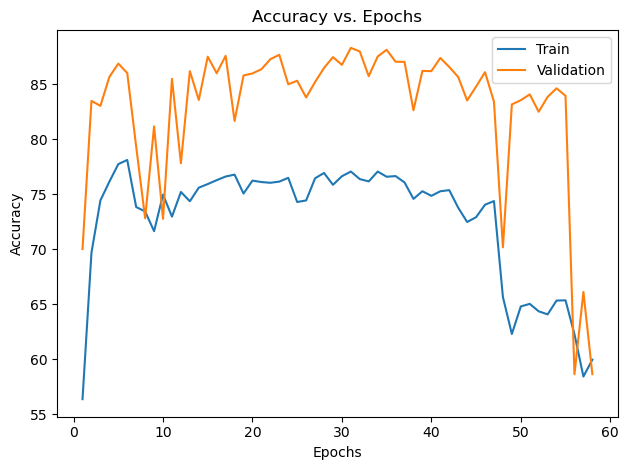

In [19]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:962: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/../MLP_utils/utils.py:963: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



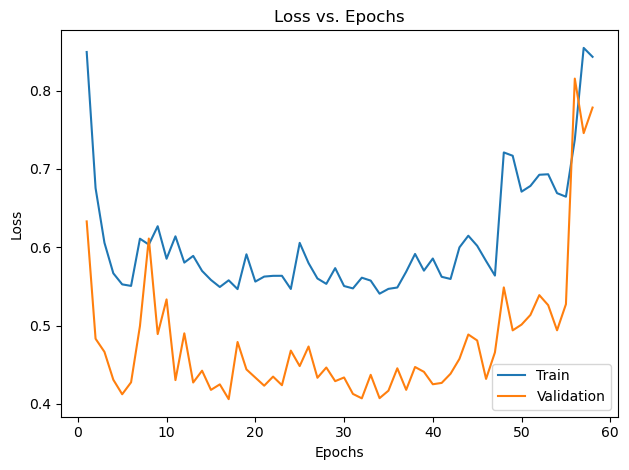

In [20]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

In [21]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3081
           1       0.75      0.96      0.84      1186
           2       0.82      0.83      0.82       987

    accuracy                           0.86      5254
   macro avg       0.84      0.87      0.85      5254
weighted avg       0.87      0.86      0.86      5254

Precision for class 0: 0.9324127906976744
Recall for class 0: 0.8328464784160987
Precision for class 1: 0.7544910179640718
Recall for class 1: 0.9561551433389545
Precision for class 2: 0.8198198198198198
Recall for class 2: 0.8297872340425532
3


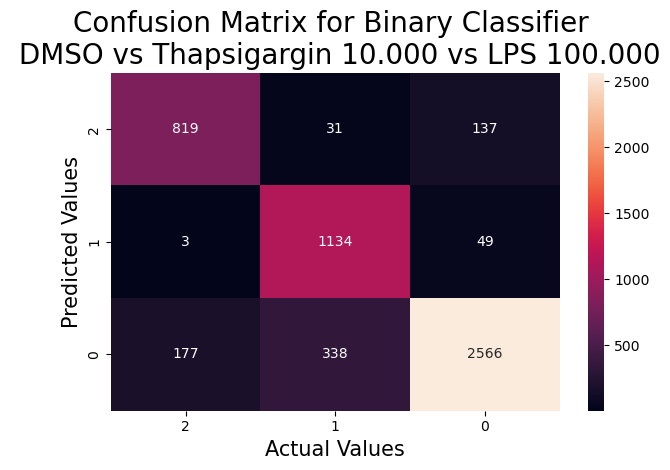

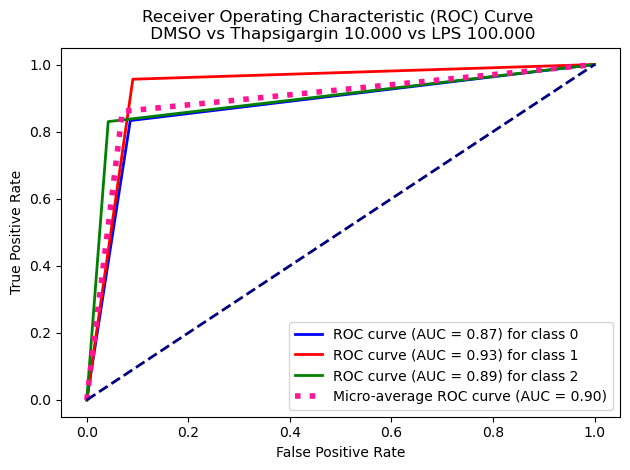

In [22]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=title,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [23]:
for i, j in zip(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
):
    print(i, j)

0 DMSO_0.100_DMSO_0.025
2 Thapsigargin_10.000_DMSO_0.025
1 LPS_100.000_DMSO_0.025


#### look at the feature weights of the model

In [24]:
# get all paramters from pytorch model
lst = []
for name, param in model.named_parameters():
    # print(name, param.shape)
    lst.append(param)
feature_weights = model[0].weight.grad[0].detach().cpu().numpy()

In [25]:
col_list = []
for col in df_values.columns:
    # print(col)
    col_list.append(col)

In [26]:
# remove last 4 columns from col_list that are not features
col_list = col_list[:-4]

In [27]:
pd.set_option("display.max_colwidth", None)

df1 = pd.DataFrame(zip(col_list, feature_weights), columns=["feature", "weight"])
# change weight collumn to float
df1["weight"] = df1["weight"].astype(float)
# sort by weight
df1 = df1.sort_values(by=["weight"], ascending=False)
df1

,feature,weight
0,Cytoplasm_AreaShape_Area,0.0
1869,Cells_Texture_SumVariance_CorrMito_3_02_256,0.0
1893,Cells_Texture_Variance_CorrPM_3_02_256,0.0
1894,Cells_Texture_Variance_CorrPM_3_03_256,0.0
1895,Nuclei_AreaShape_Area,0.0
...,...,...
951,Cells_AreaShape_Compactness,0.0
952,Cells_AreaShape_ConvexArea,0.0
953,Cells_AreaShape_Eccentricity,0.0
954,Cells_AreaShape_EquivalentDiameter,0.0


In [28]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [29]:
df_descriptive

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Metadata_inducer2_concentration,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose
336238,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,5,5,DMSO,0.100
336239,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,6,6,DMSO,0.100
336240,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,3,3,7,7,DMSO,0.100
336241,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,9,9,DMSO,0.100
336242,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,10,10,DMSO,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528609,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,183,183,192,192,LPS,100.000
528610,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,186,186,195,195,LPS,100.000
528611,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,241,241,251,251,LPS,100.000
528612,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,250,250,260,260,LPS,100.000


In [30]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [31]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [32]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4837
           1       0.90      0.90      0.90      4126
           2       0.93      0.82      0.87      3346

    accuracy                           0.88     12309
   macro avg       0.89      0.88      0.88     12309
weighted avg       0.88      0.88      0.88     12309

Precision for class 0: 0.8389455455070233
Recall for class 0: 0.9013851560884846
Precision for class 1: 0.9027576197387518
Recall for class 1: 0.9045079980610761
Precision for class 2: 0.926124916051041
Recall for class 2: 0.8242677824267782
3


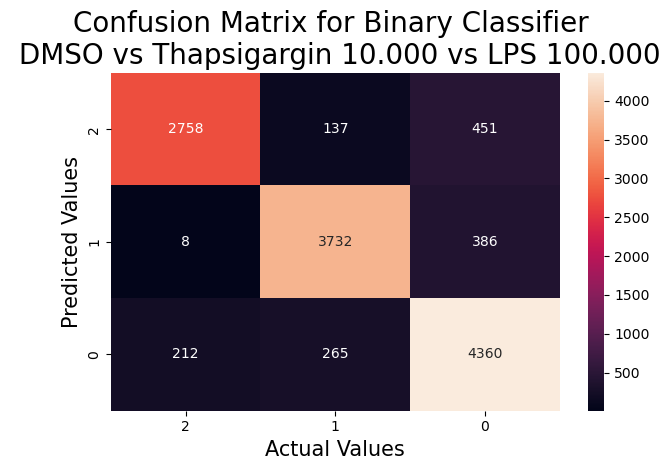

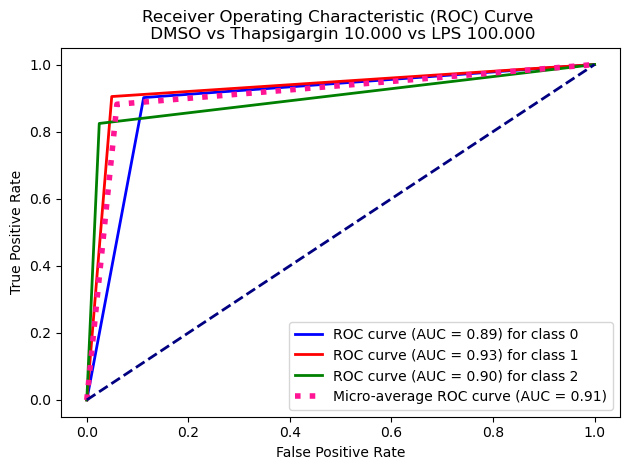

In [33]:
# Call visualization function
# calling the testing function and outputing list values of tested model

if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=title,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [34]:
for i, j in zip(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
):
    print(i, j)

0 DMSO_0.100_DMSO_0.025
2 Thapsigargin_10.000_DMSO_0.025
1 LPS_100.000_DMSO_0.025
